In [1]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
from textwrap import wrap
import torch
from torch.utils.data import DataLoader, random_split
from torch.nn.functional import softmax
from torchvision import transforms
from models.vqa_model import VQAModel, VQATransformer
from models.image_encoder import ImageEncoder, ImageEncoderTransformer
from models.question_encoder import QuestionEncoderLSTM, QuestionEncoderTransformer
from dataset import VQADataset, TransformerDataset
import config

plt.style.use('ggplot')

In [2]:
with open('saved_models/rephrasings/metrics.pkl', 'rb') as file:
    data = pickle.load(file)

In [3]:
train_acc = [i.cpu() for i in data['train']['acc']]
val_acc = [i.cpu() for i in data['val']['acc']]

train_loss = [i.cpu().detach().numpy() for i in data['train']['loss']]
val_loss = [i.cpu().detach().numpy() for i in data['val']['loss']]


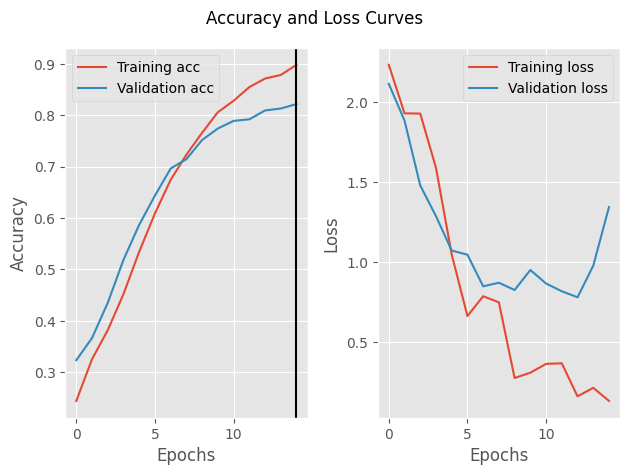

In [4]:
figure, _ = plt.subplots(1, 2)

figure.axes[0].plot(train_acc, label="Training acc")
figure.axes[0].plot(val_acc, label="Validation acc")
figure.axes[0].axvline(np.argmax(val_acc), color='k')
figure.axes[0].set_xlabel('Epochs')
figure.axes[0].set_ylabel('Accuracy')
figure.axes[0].legend()

figure.axes[1].plot(train_loss, label="Training loss")
figure.axes[1].plot(val_loss, label="Validation loss")
figure.axes[1].set_xlabel('Epochs')
figure.axes[1].set_ylabel('Loss')
figure.axes[1].legend()

figure.suptitle('Accuracy and Loss Curves')
figure.tight_layout()
figure.savefig('plots/rephrasings_outputs/acc_loss_curves.png')



In [5]:
image_encoder = ImageEncoder(pretrained=True)
question_encoder = QuestionEncoderLSTM(config.QUESTION_VOCAB_SIZE)
model = VQAModel(
    image_encoder=image_encoder,
    question_encoder=question_encoder,
    n_answers=config.ANSWERS_VOCAB_SIZE
)
model.load_state_dict(torch.load('saved_models/rephrasings/cnn_lstm_14.pth'))

/home/adityaan/anaconda3/envs/ee641/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/adityaan/anaconda3/envs/ee641/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [6]:
image_dir = os.path.join(config.DATASET_ROOT, f'val2014')
questions_file = f'./questions_subset_val_rephrasings.pkl'
questions_vocab_file = f'./questions_vocabulary_val_rephrasings.txt'
answers_vocab_file = f'./answers_vocabulary_val_rephrasings.txt'
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                        (0.229, 0.224, 0.225)),
])
dataset = VQADataset(image_dir,
                    questions_file,
                    questions_vocab_file,
                    answers_vocab_file,
                    transform=image_transforms,
                    phase='val')

# Generate training and validation sets
training_set, validation_set = random_split(dataset, 
                                            [0.8, 0.2], 
                                            torch.Generator().manual_seed(42))

invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

dataloader = DataLoader(
    dataset=validation_set,
    batch_size=4
)

27


j=2


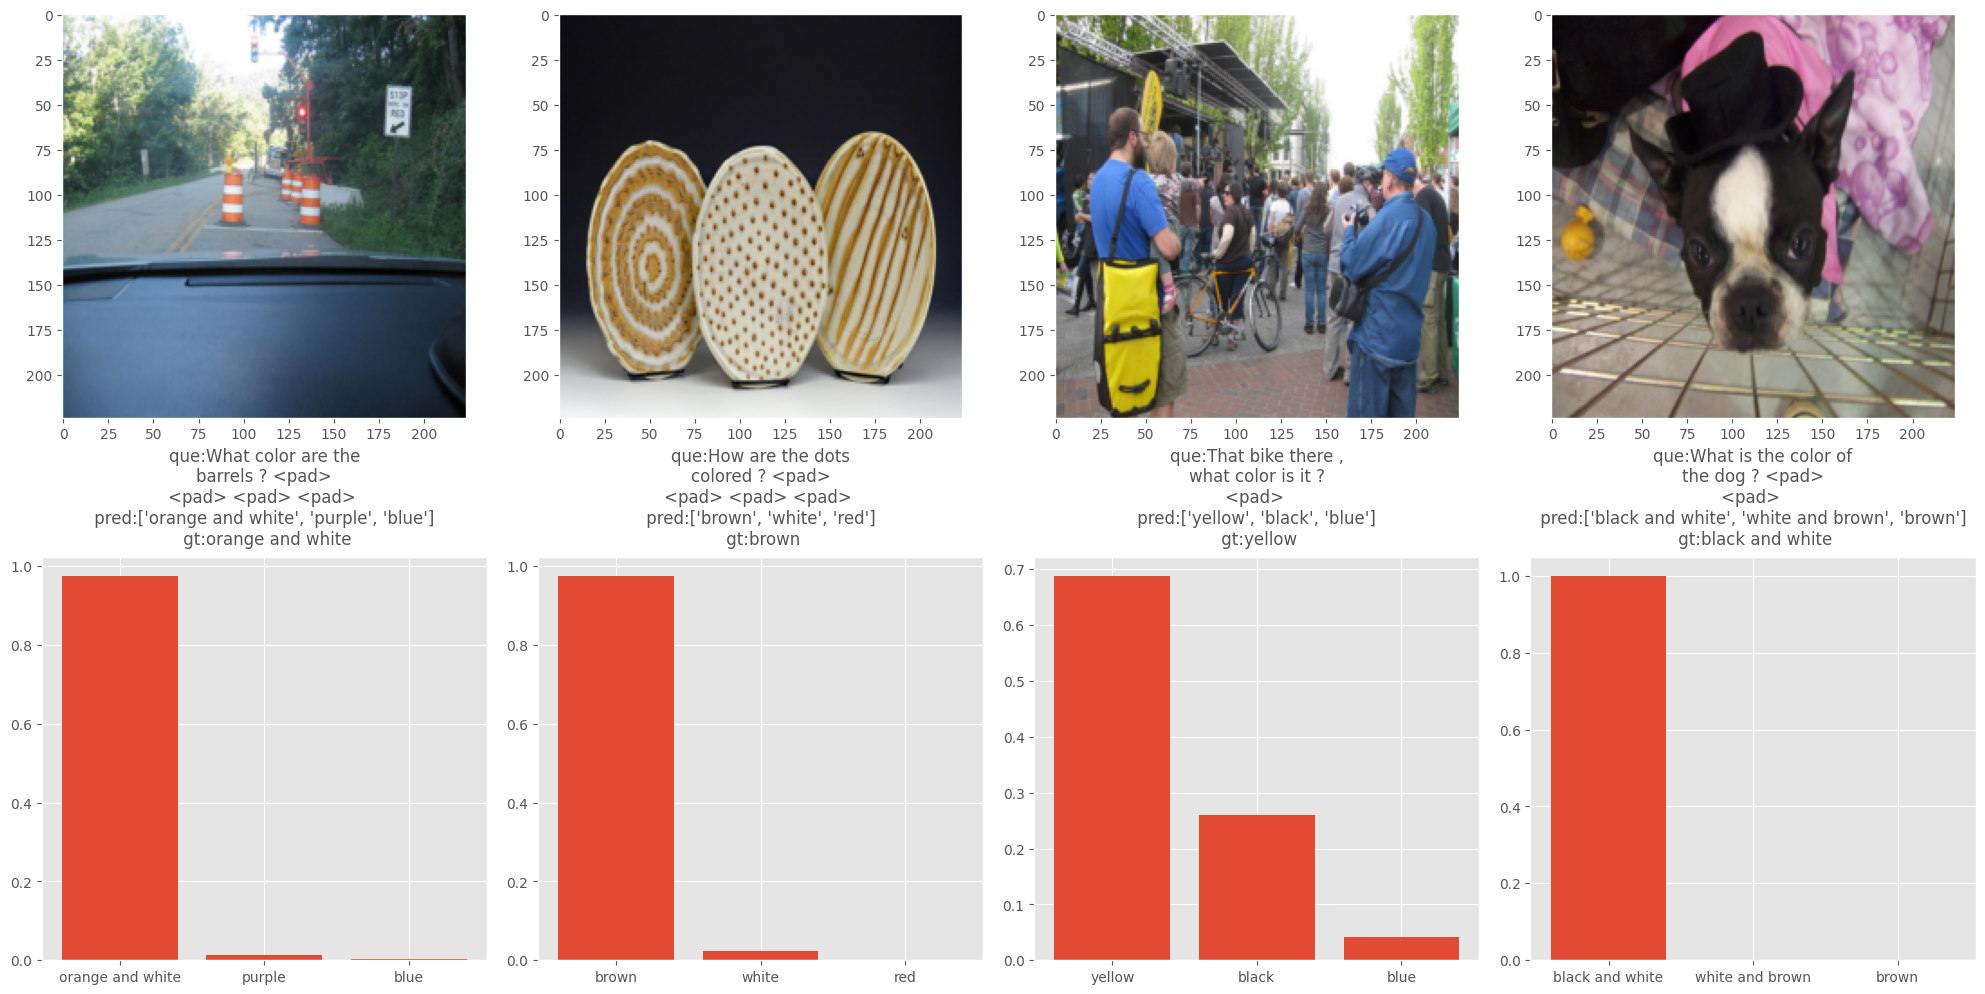

In [7]:
for j, (img, que, ans) in enumerate(dataloader):
    if j != 2:
        continue
    
    print(f"{j=}")

    model.eval()
    
    output = model(img, que)
    predictions = torch.argmax(output, dim=1)
    top_ans = torch.argsort(output, dim=1, descending=True)
    
    with torch.no_grad():
        probabilities = softmax(output, dim=1)
    
    figure, _ = plt.subplots(2, 4)
    figure.set_size_inches(20, 10)

    for i, out in enumerate(top_ans):
        figure.axes[i].imshow(invTrans(img[i]).permute(1, 2, 0))
        question = ' '.join([dataset.question_vocab.idx2word(int(i)) for i in que[i]][:10])
        question = '\n'.join(wrap(question, 20))
        answer_pred = [dataset.answers_master[int(out[k])] for k in range(3)]

        figure.axes[i].set_xlabel(f"que:{question} \n pred:{answer_pred} \n gt:{dataset.answers_master[ans[i]]}")
        figure.axes[i+4].bar(answer_pred, probabilities[i].sort(descending=True)[0][:3])
        figure.axes[i].grid(False)
    figure.tight_layout()
    figure.savefig('plots/rephrasings_outputs/finetuned.png')
    plt.show()
    if j > 2:
        break
    
    #2138216601

In [8]:
image_encoder = ImageEncoder(pretrained=True)
question_encoder = QuestionEncoderLSTM(config.QUESTION_VOCAB_SIZE)
vqa_model = VQAModel(
    image_encoder=image_encoder,
    question_encoder=question_encoder,
    n_answers=config.ANSWERS_VOCAB_SIZE
)
vqa_model.load_state_dict(torch.load('saved_models/cnn_lstm_6.pth'))

/home/adityaan/anaconda3/envs/ee641/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/adityaan/anaconda3/envs/ee641/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

j=2


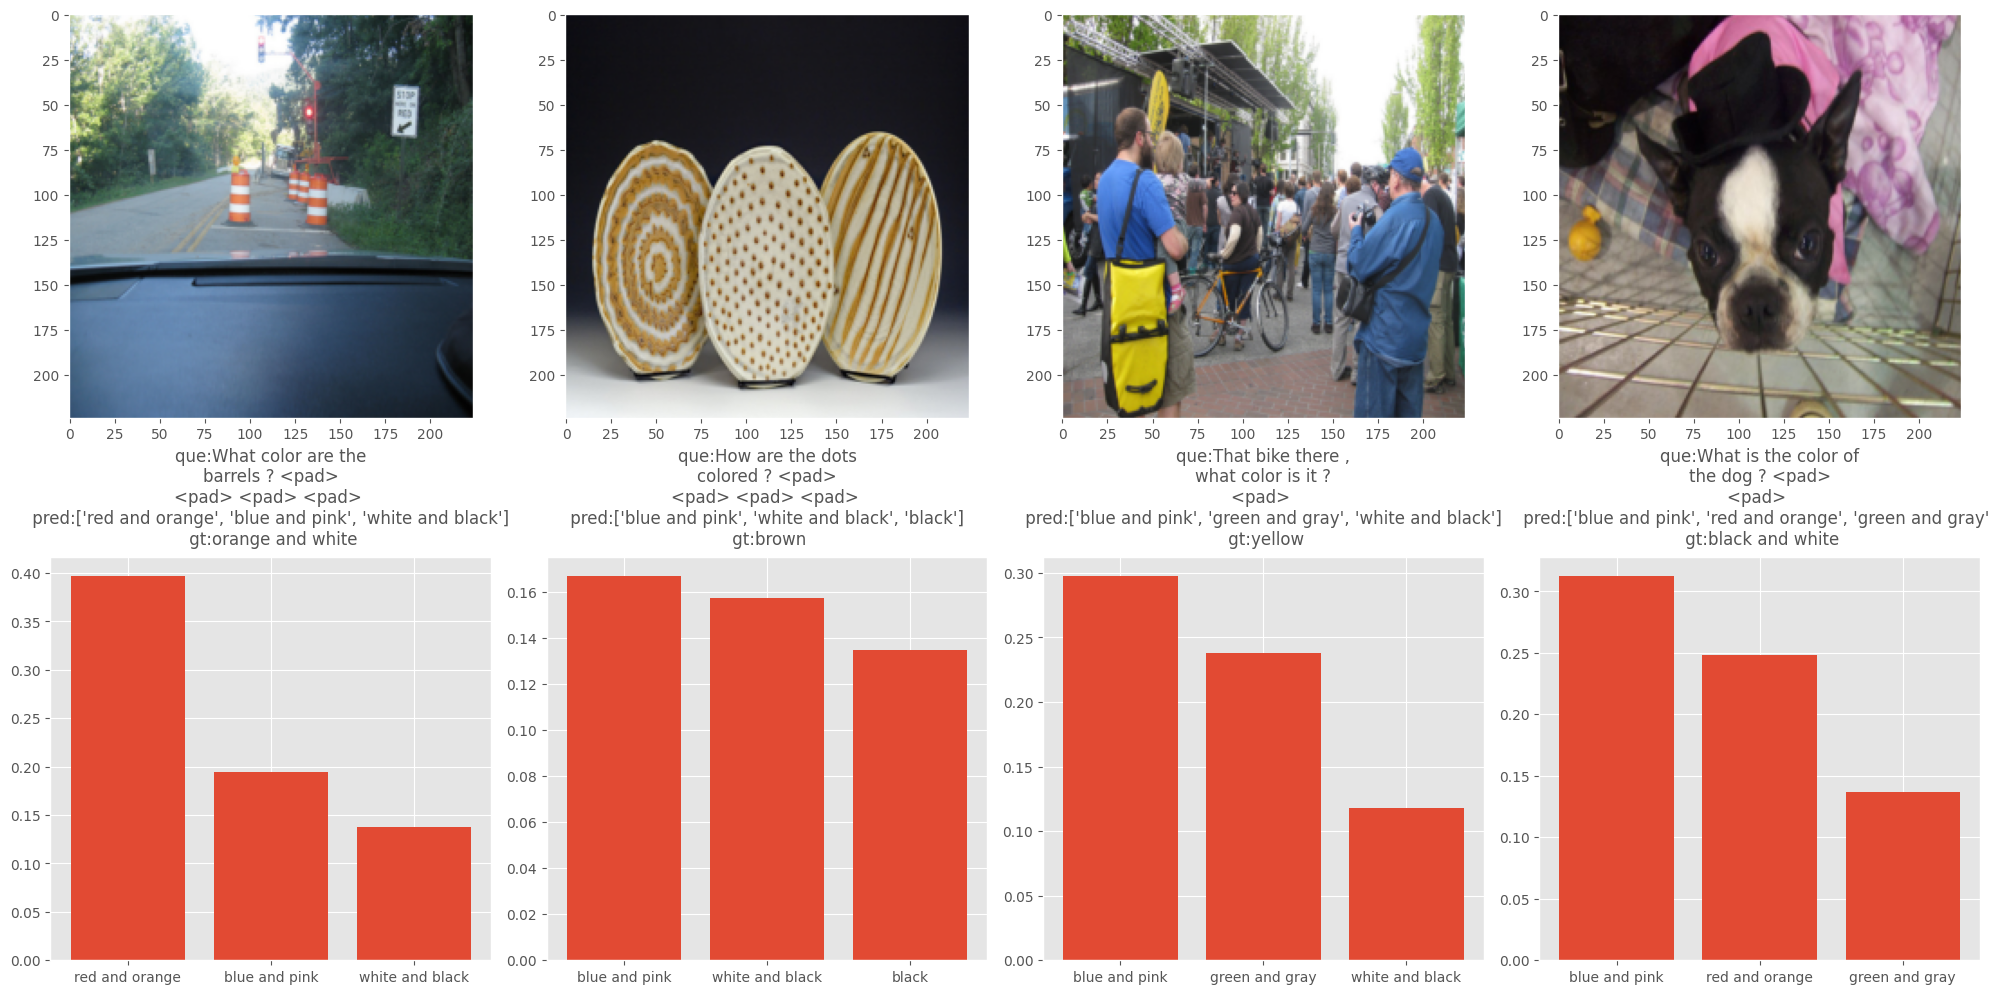

In [9]:
for j, (img, que, ans) in enumerate(dataloader):
    if j != 2:
        continue
    print(f"{j=}")

    vqa_model.eval()
    
    output = vqa_model(img, que)
    predictions = torch.argmax(output, dim=1)
    top_ans = torch.argsort(output, dim=1, descending=True)
    
    with torch.no_grad():
        probabilities = softmax(output, dim=1)
    
    figure, _ = plt.subplots(2, 4)
    figure.set_size_inches(20, 10)

    for i, out in enumerate(top_ans):
        figure.axes[i].imshow(invTrans(img[i]).permute(1, 2, 0))
        question = ' '.join([dataset.question_vocab.idx2word(int(i)) for i in que[i]][:10])
        question = '\n'.join(wrap(question, 20))
        answer_pred = [dataset.answers_master[int(out[k])] for k in range(3)]

        figure.axes[i].set_xlabel(f"que:{question} \n pred:{answer_pred} \n gt:{dataset.answers_master[ans[i]]}")
        figure.axes[i+4].bar(answer_pred, probabilities[i].sort(descending=True)[0][:3])
        figure.axes[i].grid(False)
    figure.tight_layout()
    figure.savefig('plots/rephrasings_outputs/baseline.png')
    plt.show()
    if j > 2:
        break
    
    #2138216601

In [2]:
image_dir = os.path.join(config.DATASET_ROOT, f'val2014')
questions_file = f'./questions_subset_val_rephrasings.pkl'
questions_vocab_file = f'./questions_vocabulary_val_rephrasings.txt'
answers_vocab_file = f'./answers_vocabulary_val_rephrasings.txt'
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize((0.485, 0.456, 0.406),
    #                     (0.229, 0.224, 0.225)),
])
dataset = TransformerDataset(image_dir,
                            questions_file,
                            answers_vocab_file,
                            transform=image_transforms,
                            phase='val',
                            return_raw=True)

# Generate training and validation sets
training_set, validation_set = random_split(dataset, 
                                            [0.8, 0.2], 
                                            torch.Generator().manual_seed(42))

invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

dataloader = DataLoader(
    dataset=validation_set,
    batch_size=4
)

27


In [3]:
image_encoder = ImageEncoderTransformer
question_encoder = QuestionEncoderTransformer
model = VQATransformer(
    image_encoder=image_encoder,
    question_encoder=question_encoder,
    n_answers=config.ANSWERS_VOCAB_SIZE,
)
model.load_state_dict(torch.load('./saved_models/transformer_5.pth'))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

j=2


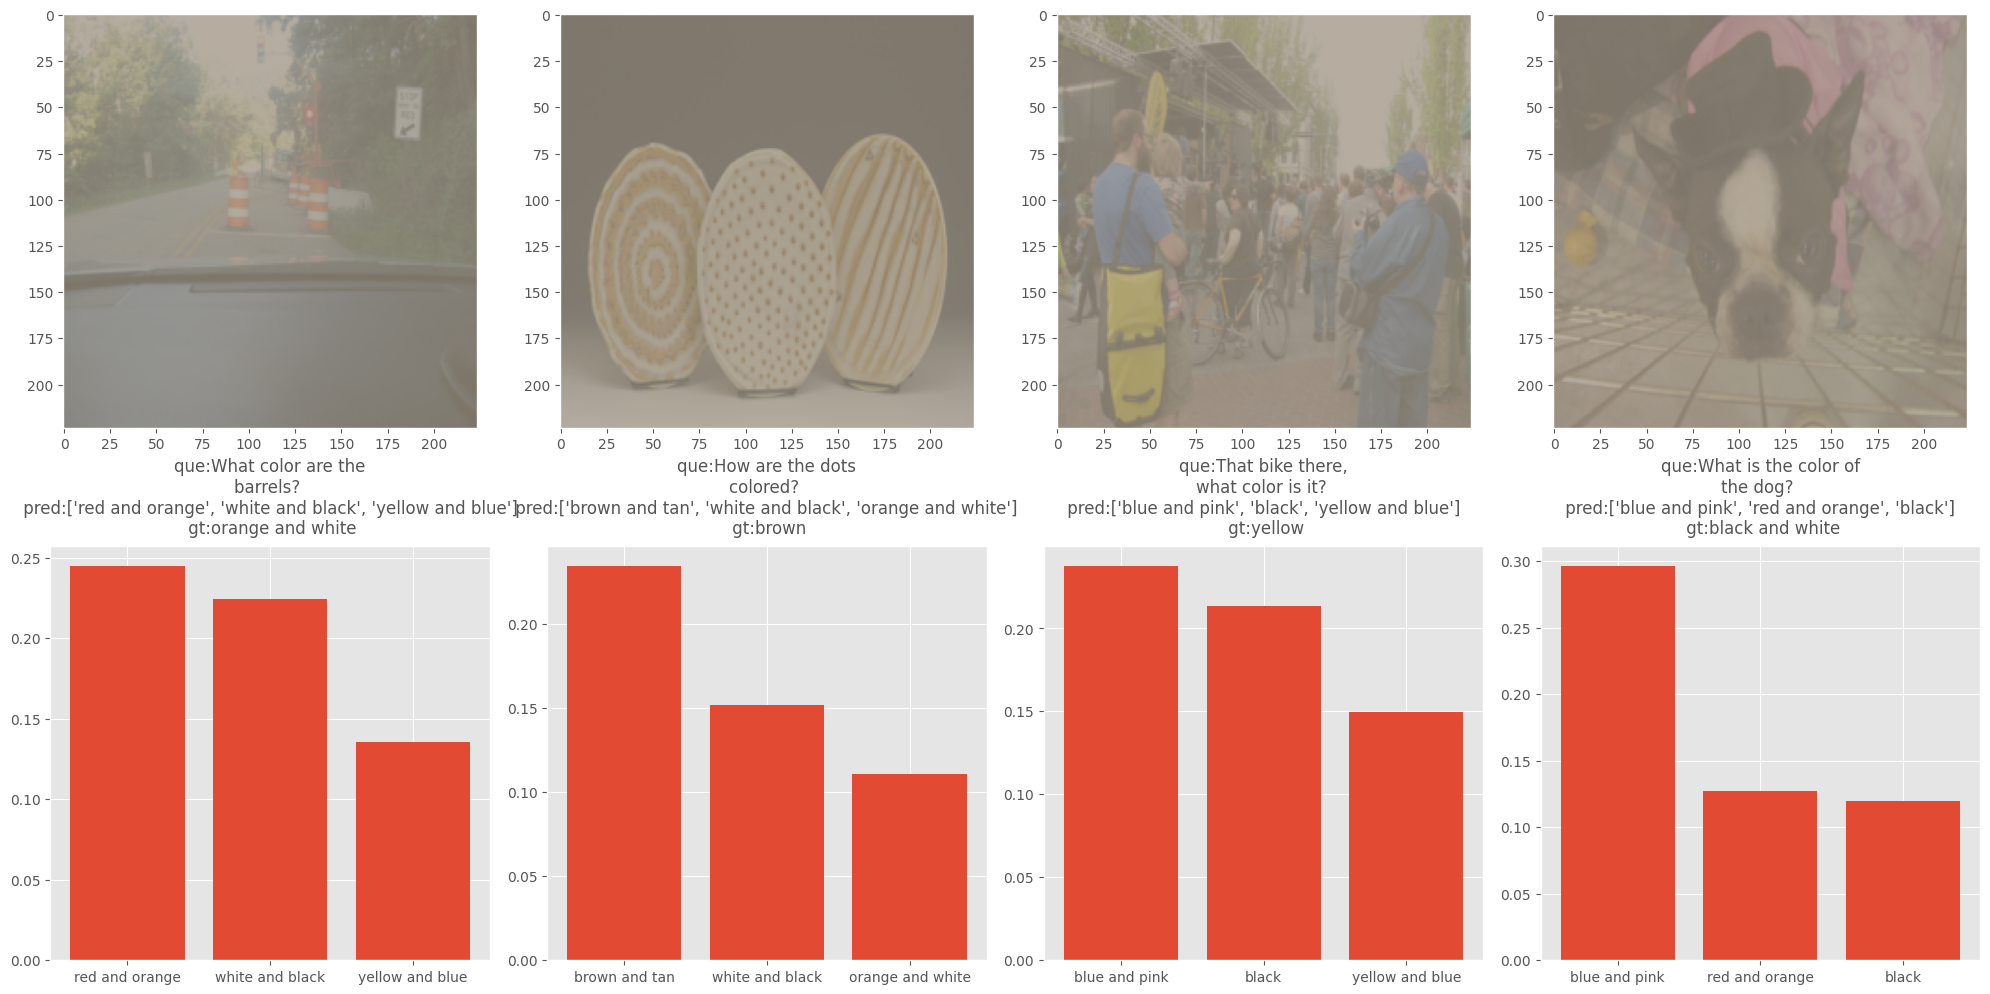

In [6]:
for j, batch in enumerate(dataloader):
    if j != 2:
        continue
    print(f"{j=}")
    img_enc, que_enc, ans, img, que = batch
    model.eval()
    
    output = model(img_enc, que_enc)
    predictions = torch.argmax(output, dim=1)
    top_ans = torch.argsort(output, dim=1, descending=True)
    
    with torch.no_grad():
        probabilities = softmax(output, dim=1)
    
    figure, _ = plt.subplots(2, 4)
    figure.set_size_inches(20, 10)

    for i, out in enumerate(top_ans):
        figure.axes[i].imshow(invTrans(img[i]).permute(1, 2, 0))
        # question = ' '.join([dataset.question_vocab.idx2word(int(i)) for i in que[i]][:10])
        question = '\n'.join(wrap(que[i], 20))
        answer_pred = [dataset.answers_master[int(out[k])] for k in range(3)]

        figure.axes[i].set_xlabel(f"que:{question} \n pred:{answer_pred} \n gt:{dataset.answers_master[ans[i]]}")
        figure.axes[i+4].bar(answer_pred, probabilities[i].sort(descending=True)[0][:3])
        figure.axes[i].grid(False)
    figure.tight_layout()
    figure.savefig('plots/rephrasings_outputs/baseline.png')
    plt.show()
    if j > 2:
        break
    
    #2138216601